In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
import MDAnalysis as mda
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis
import os
from sklearn.linear_model import LinearRegression
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import linregress
import warnings
from tqdm import tqdm  # optional progress bar
warnings.filterwarnings('ignore')
from numpy.fft import fft, fftfreq, fftshift
import random
from scipy.special import sinc
import sys
sys.path.append('../series_alignment')
import QENS

c:\Users\htchi\miniconda3\envs\series_distance\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
TOPO = "../Data/QENS/Runs_with_100fs_stepsize/Lysozyme_320K_2000ps/md.tpr" 
TRAJ = "../Data/QENS/Runs_with_100fs_stepsize/Lysozyme_320K_2000ps/md_whole.xtc"
u = mda.Universe(TOPO, TRAJ)
protein = u.select_atoms("protein")

In [3]:
all_positions = []
for ts in tqdm(u.trajectory, desc="Reading trajectory"):
    #if len(all_positions) > 2000:
    #    break
    #if int(np.round(ts.time))%2 == 0:
    all_positions.append(protein.positions)
positions = np.array(all_positions)

Reading trajectory: 100%|██████████| 20001/20001 [00:35<00:00, 568.17it/s]


In [4]:
#Q_VALUES = np.array([0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9])  # Å⁻¹
Q_VALUES = np.array([0.7])
MAX_LAG_FRACTION = 0.40     # use t < T * fraction
T0_STRIDE = 50              # time-origin stride (frames)
Fqt_dict, Sqw_dict, energy_dict = QENS.simulate_QENS(Q_VALUES, TOPO, TRAJ, positions, MAX_LAG_FRACTION, T0_STRIDE)

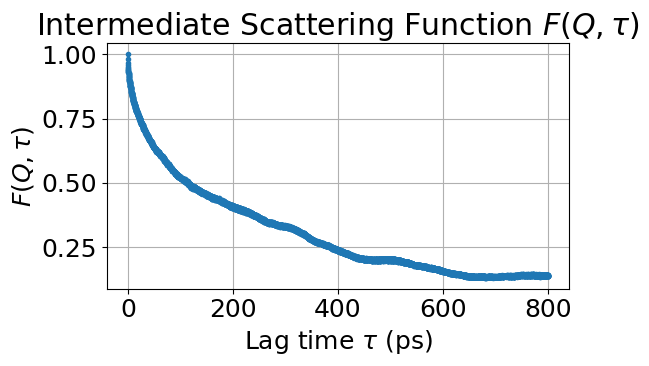

In [6]:
plt.figure(figsize=(6, 4))
for i in range(len(Q_VALUES)):
    tau_ps = np.arange(len(Fqt_dict[Q_VALUES[i]])) * u.trajectory.dt 
    plt.plot(tau_ps, Fqt_dict[Q_VALUES[i]], 'o-', ms=3)
plt.xlabel(r'Lag time $\tau$ (ps)')
plt.ylabel(r'$F(Q,\tau)$')
plt.title(r'Intermediate Scattering Function $F(Q,\tau)$')
#plt.ylim(-0.05, 1.05)
#plt.xlim([0, 4000])
plt.grid(True)
plt.tight_layout()
plt.show()

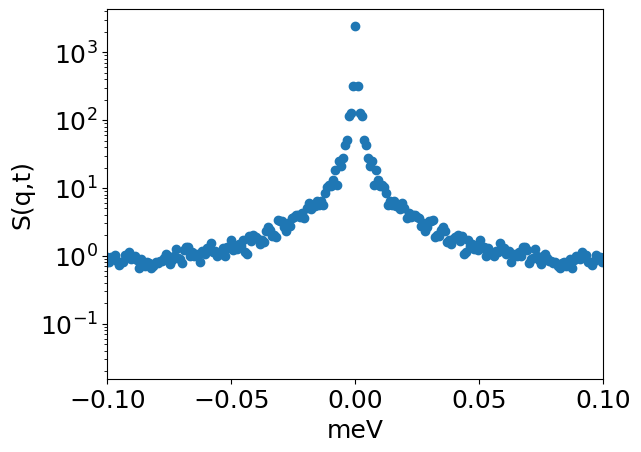

In [7]:
for i in range(len(Q_VALUES)):
    #fig, ax = plt.subplots()
    plt.scatter(energy_dict[Q_VALUES[i]], Sqw_dict[Q_VALUES[i]])
    plt.ylabel(r'S(q,t)')
    plt.xlabel(r'meV')
    #plt.ylim([0, 1])
    plt.yscale('log')
    plt.xlim(-0.1, 0.1)

In [ ]:
data_sqw = np.hstack((energy_dict[0.3].reshape(-1,1), Sqw_dict[0.3].reshape(-1,1), Sqw_dict[0.5].reshape(-1,1), Sqw_dict[0.7].reshape(-1,1), Sqw_dict[0.9].reshape(-1,1), Sqw_dict[1.1].reshape(-1,1), Sqw_dict[1.3].reshape(-1,1), Sqw_dict[1.5].reshape(-1,1), Sqw_dict[1.7].reshape(-1,1), Sqw_dict[1.9].reshape(-1,1)))
df = pd.DataFrame(data_sqw, columns=['energy meV','q=0.3','q=0.5','q=0.7','q=0.9','q=1.1','q=1.3','q=1.5','q=1.7','q=1.9'])
#df.to_csv('../Data/QENS/Runs_with_100fs_stepsize/Lysozyme_320K_2000ps/simulated_sqw.csv', index=False)

## Convolute data with instrument resolution 

In [14]:
data_sim_200 = pd.read_csv('../Data/QENS/Runs_with_100fs_stepsize/Lysozyme_200K_2000ps/simulated_sqw.csv')
data_sim_230 = pd.read_csv('../Data/QENS/Runs_with_100fs_stepsize/Lysozyme_230K_2000ps/simulated_sqw.csv')
data_sim_260 = pd.read_csv('../Data/QENS/Runs_with_100fs_stepsize/Lysozyme_260K_2000ps/simulated_sqw.csv')
data_sim_290 = pd.read_csv('../Data/QENS/Runs_with_100fs_stepsize/Lysozyme_290K_2000ps/simulated_sqw.csv')
data_sim_320 = pd.read_csv('../Data/QENS/Runs_with_100fs_stepsize/Lysozyme_320K_2000ps/simulated_sqw.csv')

In [15]:
path_290 = "../Experimental_data/QENS/BASIS_35181_1run_divided_290K.dat"
path_260 = "../Experimental_data/QENS/BASIS_35184_1run_divided_260K.dat"
path_230 = "../Experimental_data/QENS/BASIS_35187_1run_divided_230K.dat"
path_100 = "../Experimental_data/QENS/BASIS_35190_1run_divided_100K.dat"
data_290 = QENS.extract_tagged_dat(path_290)
data_260 = QENS.extract_tagged_dat(path_260)
data_230 = QENS.extract_tagged_dat(path_230)
data_100 = QENS.extract_tagged_dat(path_100)

In [24]:
data_sim_lst = [data_sim_200, data_sim_230, data_sim_260, data_sim_290, data_sim_320]
temps = ['200','230','260','290','320']
for i in range(len(data_sim_lst)):
    data_sim = data_sim_lst[i]
    exp_data_conv = data_100
    for index in range(1,10):
        exp_q = exp_data_conv['Energy transfer (micro eV) values']
        sim_energy_trunc, sim_scattering_trunc = QENS.truncate_simulated_to_experimental(exp_q, data_sim.values[:,0]*1000, data_sim.values[:,index])
        Sqw_sim = QENS.interpolate_simulated_to_experimental(exp_q, sim_energy_trunc, sim_scattering_trunc)
        Sqw_convolve = QENS.convolve_with_resolution(Sqw_sim.flatten(), exp_data_conv['Group ' + str(index-1)][:,0].flatten(), exp_q.flatten(), 0.65)
        if index == 1: 
            data_array = np.hstack((exp_q.reshape(-1,1), Sqw_convolve.reshape(-1,1)))
        else:
            data_array = np.hstack((data_array, Sqw_convolve.reshape(-1,1)))
    df = pd.DataFrame(data_array, columns=['energy (micro) eV','q=0.3','q=0.5','q=0.7','q=0.9','q=1.1','q=1.3','q=1.5','q=1.7','q=1.9'])
    df.to_csv('../Data/QENS/Runs_with_100fs_stepsize/Lysozyme_' + str(temps[i]) + 'K_2000ps/simulated_sqw_conv_2.csv', index=False)

In [14]:
# plt.plot(data_100['Energy transfer (micro eV) values'], data_100['Group 0'][:,0])
# plt.plot(data_sim_290.values[:,0]*1000, data_sim_290.values[:,index])
# #plt.plot(data_100['Energy transfer (micro eV) values'], Sqw_sim)
# # plt.plot(data_100['Energy transfer (micro eV) values'], Sqw_convolve)
# plt.yscale('log')
# plt.xlim(-100, 100)

## Plot Experimental and Simulation Data

In [2]:
path_290 = "../Experimental_data/QENS/BASIS_35181_1run_divided_290K.dat"
path_260 = "../Experimental_data/QENS/BASIS_35184_1run_divided_260K.dat"
path_230 = "../Experimental_data/QENS/BASIS_35187_1run_divided_230K.dat"
path_100 = "../Experimental_data/QENS/BASIS_35190_1run_divided_100K.dat"
data_290 = QENS.extract_tagged_dat(path_290)
data_260 = QENS.extract_tagged_dat(path_260)
data_230 = QENS.extract_tagged_dat(path_230)
data_100 = QENS.extract_tagged_dat(path_100)

In [3]:
data_sim_200 = pd.read_csv('../Data/QENS/Runs_with_100fs_stepsize/Lysozyme_200K_2000ps/simulated_sqw_conv_2.csv')
data_sim_230 = pd.read_csv('../Data/QENS/Runs_with_100fs_stepsize/Lysozyme_230K_2000ps/simulated_sqw_conv_2.csv')
data_sim_260 = pd.read_csv('../Data/QENS/Runs_with_100fs_stepsize/Lysozyme_260K_2000ps/simulated_sqw_conv_2.csv')
data_sim_290 = pd.read_csv('../Data/QENS/Runs_with_100fs_stepsize/Lysozyme_290K_2000ps/simulated_sqw_conv_2.csv')
data_sim_320 = pd.read_csv('../Data/QENS/Runs_with_100fs_stepsize/Lysozyme_320K_2000ps/simulated_sqw_conv_2.csv')

In [4]:
# #plt.plot(data_sim_290.values[:,0], data_sim_290.values[:,5], linewidth = 3, color='k')
# plt.scatter(data_290['Energy transfer (micro eV) values'], data_290['Group 5'][:,0], linewidth = 2, color='red')
# plt.yscale('log')
# plt.xlim(-100,100)
# plt.axis('off')
# # plt.savefig('../Figures/exp_data.png', dpi=600, bbox_inches="tight")

In [5]:
data_sim = data_sim_320
data_sim2 = data_sim_290
data = data_290

In [6]:
data_sim

,energy (micro) eV,q=0.3,q=0.5,q=0.7,q=0.9,q=1.1,q=1.3,q=1.5,q=1.7,q=1.9
0,-119.6,0.000065,0.000103,0.000137,0.000172,0.000183,0.000225,0.000263,0.000308,0.000381
1,-118.8,0.000067,0.000109,0.000137,0.000166,0.000197,0.000224,0.000252,0.000306,0.000370
2,-118.0,0.000069,0.000110,0.000153,0.000178,0.000193,0.000236,0.000271,0.000313,0.000386
3,-117.2,0.000073,0.000126,0.000147,0.000180,0.000209,0.000247,0.000268,0.000316,0.000382
4,-116.4,0.000067,0.000112,0.000154,0.000175,0.000201,0.000240,0.000268,0.000312,0.000376
...,...,...,...,...,...,...,...,...,...,...
295,116.4,0.000069,0.000121,0.000144,0.000168,0.000193,0.000239,0.000268,0.000306,0.000372
296,117.2,0.000067,0.000112,0.000154,0.000175,0.000201,0.000240,0.000268,0.000312,0.000376
297,118.0,0.000073,0.000126,0.000147,0.000180,0.000209,0.000247,0.000268,0.000316,0.000382
298,118.8,0.000069,0.000110,0.000153,0.000178,0.000193,0.000236,0.000271,0.000313,0.000386


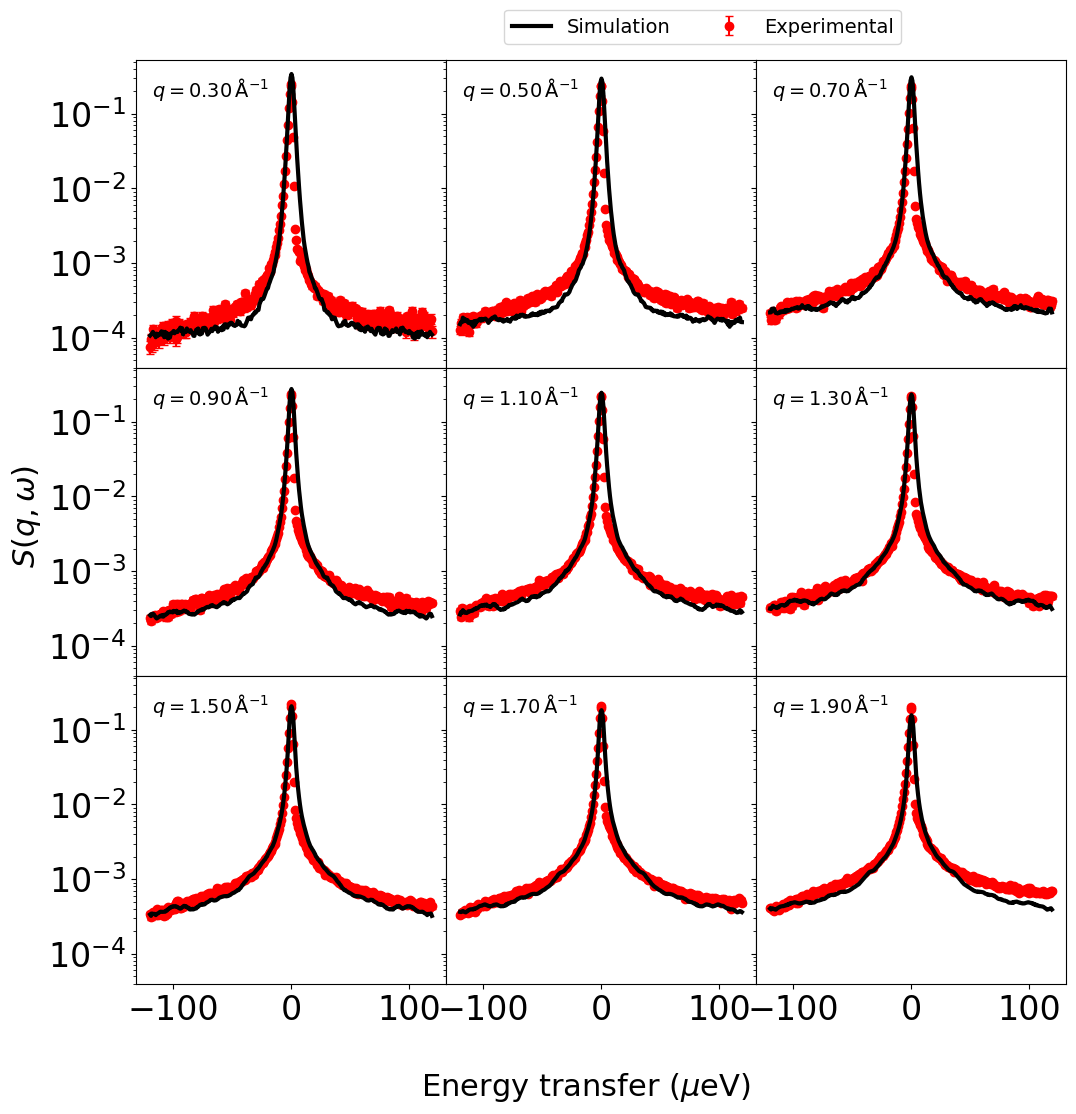

In [7]:
plt.rcParams.update({'font.size': 24})
nrows, ncols = 3, 3
fig, axes = plt.subplots(
    nrows,
    ncols,
    figsize=(12, 12),
    sharex=True,
    sharey=True
)

axes = axes.flatten()

for i, ax in enumerate(axes):
    if i >= data_sim.shape[1] - 1:
        ax.axis("off")
        continue

    q = data['q (1/Angstrom) values'][i][0]

    # ----- Experimental -----
    area = np.trapezoid(
        data['Energy transfer (micro eV) values'][:, 0],
        data['Group ' + str(i)][:, 0]
    )

    exp_energy = data['Energy transfer (micro eV) values'][:, 0]
    exp_scattering = data['Group ' + str(i)][:, 0] / -area
    exp_uncertainty = data['Group ' + str(i)][:, 1] / -area

    ax.errorbar(
        exp_energy,
        exp_scattering,
        yerr=exp_uncertainty,
        fmt='o',
        linestyle='none',
        capsize=3,
        label='Experimental',
        zorder=1,
        color='red'
    )

    # ----- Simulated -----
    area = np.trapezoid(
        data_sim['energy (micro) eV'].values,
        data_sim['q=' + str(q)].values
    )

    sim_energy = data_sim['energy (micro) eV'].values
    sim_scattering = data_sim['q=' + str(q)].values / -area

    sim_energy_trunc, sim_scattering_trunc = QENS.truncate_simulated_to_experimental(
        exp_energy,
        sim_energy,
        sim_scattering
    )

    sim_scattering_interp = QENS.interpolate_simulated_to_experimental(
        exp_energy,
        sim_energy_trunc,
        sim_scattering_trunc
    )

    normalization_const = np.mean(exp_scattering[0:20]) / np.mean(sim_scattering_interp[0:20])
    sim_scattering_interp *= normalization_const

    ax.plot(
        exp_energy,
        sim_scattering_interp,
        linewidth=3,
        label='Simulation',
        zorder=3,
        color='black'
    )

    #  # ----- Simulated -----
    # area = np.trapezoid(
    #     data_sim2['energy (micro) eV'].values,
    #     data_sim2['q=' + str(q)].values
    # )

    # sim_energy = data_sim2['energy (micro) eV'].values
    # sim_scattering = data_sim2['q=' + str(q)].values / -area

    # sim_energy_trunc, sim_scattering_trunc = QENS.truncate_simulated_to_experimental(
    #     exp_energy,
    #     sim_energy,
    #     sim_scattering
    # )

    # sim_scattering_interp = QENS.interpolate_simulated_to_experimental(
    #     exp_energy,
    #     sim_energy_trunc,
    #     sim_scattering_trunc
    # )


    # normalization_const = np.mean(exp_scattering[0:20]) / np.mean(sim_scattering_interp[0:20])
    # sim_scattering_interp *= normalization_const

    # ax.plot(
    #     exp_energy,
    #     sim_scattering_interp,
    #     linewidth=3,
    #     label='Simulation',
    #     zorder=3,
    #     color='blue'
    # )

    ax.set_yscale('log')
    #ax.set_xlim(-100, 100)
    ax.text(
    0.05, 0.95,
    rf'$q = {q:.2f}\,\mathrm{{\AA^{{-1}}}}$',
    transform=ax.transAxes,
    fontsize=14,
    va='top',
    ha='left'
)

#plt.yticks([])
# ----- Global labels -----
fig.supxlabel(r'Energy transfer ($\mu$eV)', fontsize=22)
fig.supylabel(r'$S(q,$$\omega$$)$', fontsize=22)

# ----- Remove gaps & borders -----
plt.subplots_adjust(wspace=0, hspace=0)

# ----- Single legend -----
plt.legend(loc='lower right', bbox_to_anchor=(0.5, 3.02), ncol=3, fontsize=14)
#plt.savefig('../Figures/QENS_Comparison_big_font.png', dpi=600, bbox_inches="tight")
plt.show()
